In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

from eye_tracker_dataset import EyeTrackerDataset

In [2]:
class EyeTrackerNet(nn.Module) :
    def __init__(self) :
        super(EyeTrackerNet, self).__init__()

        self.fc1 = nn.Linear(81 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 2)

    def forward(self, x) :
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        return x

model = EyeTrackerNet()


In [3]:
eye_tracker_dataset = EyeTrackerDataset()
print(len(eye_tracker_dataset))

torch_generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(eye_tracker_dataset, [0.7, 0.3], generator=torch_generator)
print(len(train_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader  = DataLoader(test_dataset,  batch_size = 64, shuffle = True)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 0.0001
)
y = model(eye_tracker_dataset[0][0].flatten())

3047
2133 914


In [7]:
def train_one_epoch(train_loader):
    loss_accumulated = 0
    n_data_accumulated = 0

    with tqdm(
        total = len(train_loader),
        desc = "train"
    ) as inner_pbar :
        for i, data in enumerate(train_loader):
            inputs, labels = data
            n_data = inputs.shape[0]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            curr_loss  = loss.item()
            loss_accumulated += loss.item() * n_data
            n_data_accumulated += n_data
            whole_mean_loss = loss_accumulated / n_data_accumulated

            inner_pbar.update(1)
            inner_pbar.set_postfix_str(curr_loss)
            
    return whole_mean_loss

def valid_one_epoch(valid_loader) :
    loss_accumulated = 0
    n_data_accumulated = 0

    with tqdm(
        total = len(valid_loader),
        desc = "valid"
    ) as inner_pbar :
        for i, data in enumerate(valid_loader):
            inputs, labels = data
            n_data = inputs.shape[0]

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            curr_loss  = loss.item()
            loss_accumulated += loss.item() * n_data
            n_data_accumulated += n_data
            whole_mean_loss = loss_accumulated / n_data_accumulated

            inner_pbar.update(1)
            inner_pbar.set_postfix_str(curr_loss)
            
    return whole_mean_loss

In [8]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
N_MODEL_TO_SAVE = 3

model_dict_list = []
train_loss_list = []
valid_loss_list = []
train_valid_loop_cache = [{"valid_loss":100}]

curr_epoch_idx = 0

  0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09875 vloss : 0.09933


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09802 vloss : 0.09904


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09779 vloss : 0.09867


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09743 vloss : 0.09824


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09699 vloss : 0.09790


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09652 vloss : 0.09740


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09608 vloss : 0.09681


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09558 vloss : 0.09658


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09500 vloss : 0.09584


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09438 vloss : 0.09520


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09378 vloss : 0.09476


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09308 vloss : 0.09390


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09223 vloss : 0.09318


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09129 vloss : 0.09221


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.09022 vloss : 0.09086


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.08908 vloss : 0.08962


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.08772 vloss : 0.08862


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.08610 vloss : 0.08647


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.08416 vloss : 0.08464


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.08176 vloss : 0.08183


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.07908 vloss : 0.07880


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.07567 vloss : 0.07529


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.07191 vloss : 0.07121


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.06765 vloss : 0.06742


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.06382 vloss : 0.06372


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.06071 vloss : 0.06096


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05843 vloss : 0.05964


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05647 vloss : 0.05787


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05533 vloss : 0.05725


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05506 vloss : 0.05714


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05442 vloss : 0.05683


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05423 vloss : 0.05647


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05395 vloss : 0.05638


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05385 vloss : 0.05645


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05371 vloss : 0.05606


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05359 vloss : 0.05599


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05339 vloss : 0.05612


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05334 vloss : 0.05574


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05322 vloss : 0.05562


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05309 vloss : 0.05700


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05310 vloss : 0.05546


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05279 vloss : 0.05535


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05265 vloss : 0.05520


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05249 vloss : 0.05508


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05241 vloss : 0.05537


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05226 vloss : 0.05481


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05211 vloss : 0.05469


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05199 vloss : 0.05461


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05180 vloss : 0.05438


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05153 vloss : 0.05437


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05156 vloss : 0.05392


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05118 vloss : 0.05372


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05100 vloss : 0.05352


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05073 vloss : 0.05326


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05057 vloss : 0.05295


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.05023 vloss : 0.05293


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04985 vloss : 0.05231


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04955 vloss : 0.05179


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04897 vloss : 0.05126


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04838 vloss : 0.05119


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04775 vloss : 0.05004


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04685 vloss : 0.04938


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04612 vloss : 0.04768


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04450 vloss : 0.04642


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04281 vloss : 0.04456


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.04094 vloss : 0.04281


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03901 vloss : 0.04059


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03714 vloss : 0.03884


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03569 vloss : 0.03730


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03482 vloss : 0.03607


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03324 vloss : 0.03594


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03272 vloss : 0.03504


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03237 vloss : 0.03547


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03241 vloss : 0.03483


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03190 vloss : 0.03473


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03190 vloss : 0.03427


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03166 vloss : 0.03421


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03141 vloss : 0.03396


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03156 vloss : 0.03389


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03135 vloss : 0.03412


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03139 vloss : 0.03369


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03103 vloss : 0.03366


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03113 vloss : 0.03359


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03088 vloss : 0.03341


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03071 vloss : 0.03374


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03109 vloss : 0.03328


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03101 vloss : 0.03323


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03070 vloss : 0.03324


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03087 vloss : 0.03325


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03061 vloss : 0.03323


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03047 vloss : 0.03338


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03071 vloss : 0.03295


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03040 vloss : 0.03359


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03073 vloss : 0.03303


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03033 vloss : 0.03360


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03056 vloss : 0.03272


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03034 vloss : 0.03298


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03059 vloss : 0.03271


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03044 vloss : 0.03291


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03025 vloss : 0.03263


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03036 vloss : 0.03274


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03016 vloss : 0.03264


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03021 vloss : 0.03249


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03014 vloss : 0.03349


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03031 vloss : 0.03264


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02998 vloss : 0.03256


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02995 vloss : 0.03349


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03005 vloss : 0.03290


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03008 vloss : 0.03246


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02974 vloss : 0.03222


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03046 vloss : 0.03288


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02980 vloss : 0.03233


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02966 vloss : 0.03208


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02986 vloss : 0.03202


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02957 vloss : 0.03263


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02956 vloss : 0.03200


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02959 vloss : 0.03200


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02947 vloss : 0.03202


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.03020 vloss : 0.03184


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02947 vloss : 0.03188


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02964 vloss : 0.03196


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02941 vloss : 0.03193


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02939 vloss : 0.03229


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02949 vloss : 0.03205


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02941 vloss : 0.03220


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02948 vloss : 0.03187


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02964 vloss : 0.03174


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02927 vloss : 0.03238


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02930 vloss : 0.03186


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02941 vloss : 0.03279


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02954 vloss : 0.03159


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02924 vloss : 0.03274


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02919 vloss : 0.03158


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02910 vloss : 0.03161


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02908 vloss : 0.03156


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02913 vloss : 0.03171


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02919 vloss : 0.03231


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02912 vloss : 0.03186


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02937 vloss : 0.03183


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02897 vloss : 0.03151


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02914 vloss : 0.03192


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02920 vloss : 0.03167


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02957 vloss : 0.03148


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02933 vloss : 0.03201


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02945 vloss : 0.03156


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02894 vloss : 0.03180


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02897 vloss : 0.03151


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02886 vloss : 0.03157


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02890 vloss : 0.03173


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02893 vloss : 0.03196


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02925 vloss : 0.03159


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02892 vloss : 0.03129


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02871 vloss : 0.03124


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02890 vloss : 0.03135


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02876 vloss : 0.03123


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02882 vloss : 0.03364


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02976 vloss : 0.03268


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02900 vloss : 0.03118


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02864 vloss : 0.03143


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02873 vloss : 0.03194


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02871 vloss : 0.03121


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02879 vloss : 0.03165


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02897 vloss : 0.03124


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02875 vloss : 0.03120


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02873 vloss : 0.03177


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02864 vloss : 0.03115


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02868 vloss : 0.03117


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02867 vloss : 0.03112


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02858 vloss : 0.03165


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02911 vloss : 0.03201


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02863 vloss : 0.03118


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02847 vloss : 0.03175


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02868 vloss : 0.03111


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02860 vloss : 0.03143


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02892 vloss : 0.03101


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02852 vloss : 0.03096


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02852 vloss : 0.03096


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02835 vloss : 0.03120


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02837 vloss : 0.03153


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02862 vloss : 0.03101


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02842 vloss : 0.03094


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02832 vloss : 0.03116


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02828 vloss : 0.03177


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02862 vloss : 0.03099


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02862 vloss : 0.03184


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02895 vloss : 0.03100


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02853 vloss : 0.03092


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02840 vloss : 0.03097


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02841 vloss : 0.03104


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02869 vloss : 0.03103


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02839 vloss : 0.03109


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02840 vloss : 0.03096


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02851 vloss : 0.03170


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02843 vloss : 0.03094


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02829 vloss : 0.03092


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02828 vloss : 0.03097


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02867 vloss : 0.03095


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02880 vloss : 0.03096


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02840 vloss : 0.03100


train:   0%|          | 0/34 [00:00<?, ?it/s]

valid:   0%|          | 0/15 [00:00<?, ?it/s]

tloss : 0.02841 vloss : 0.03078


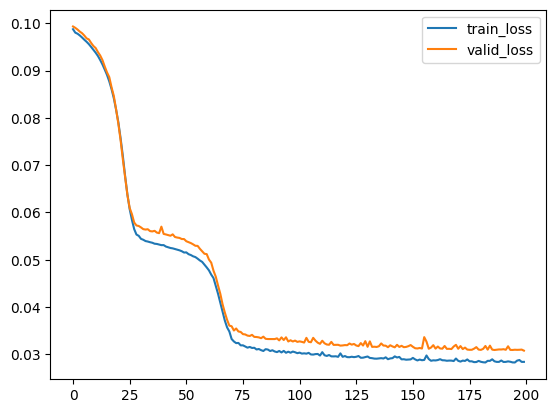

In [9]:
N_EPOCHS = 200

with tqdm(total=N_EPOCHS) as outer_pbar :
    for epoch in range(curr_epoch_idx, curr_epoch_idx + N_EPOCHS) :
        curr_epoch_idx = epoch
        model.train(True)
        whole_mean_loss_train = train_one_epoch(train_loader)
        train_loss_list.append(whole_mean_loss_train)

        model.train(False)        
        whole_mean_loss_valid = valid_one_epoch(test_loader)
        valid_loss_list.append(whole_mean_loss_valid)

        if whole_mean_loss_valid < train_valid_loop_cache[-1]["valid_loss"] :
            train_valid_loop_cache.append({
                "state_dict": model.state_dict().copy(),
                "train_loss": whole_mean_loss_train,
                "valid_loss": whole_mean_loss_valid,
                "epoch"     : epoch
            })
            train_valid_loop_cache.sort(key = lambda data: data["valid_loss"])
            if len(train_valid_loop_cache) > N_MODEL_TO_SAVE :
                train_valid_loop_cache.pop(-1)

        outer_pbar.update(1)
        outer_pbar.set_postfix_str(str(whole_mean_loss_valid))

        print("tloss : {:.5f} vloss : {:.5f}".format(whole_mean_loss_train, whole_mean_loss_valid))

for model_data in train_valid_loop_cache :
    model_path = os.path.join(
        "checkpoints",
        'model_{}_{}'.format(timestamp, model_data["epoch"])
    )
    torch.save(model_data["state_dict"], model_path)

plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
epoch